In [1]:
import os
import copy
import numpy as np
import pickle
import warnings
import scipy.io as sio
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import SimpleITK as sitk
import calc_t1map_py as t1_py
from Optimize import Optimize
import ants


def load_orig_file(mat_fname):
    mat_contents = sio.loadmat(mat_fname)
    tvec = np.squeeze(mat_contents['tvec']).astype(np.float32)
    frames = np.squeeze(mat_contents['img']).astype(np.float32)
    return tvec, frames


def view(img):
    img = sitk.GetImageFromArray(img.transpose(2, 1, 0))
    image_viewer = sitk.ImageViewer()
    image_viewer.SetTitle('grid using ImageViewer class')

    image_viewer.SetApplication('/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP')
    # image_viewer.SetApplication('/Applications/Fiji.app/Contents/MacOS/ImageJ-macosx')
    image_viewer.Execute(img)
    

# def t1fitting(ini_frames, ini_tvec, tvec):
#     t1_params_pre = t1_py.calculate_T1map(ini_frames, ini_tvec)

#     a = t1_params_pre[:, :, 0]
#     b = t1_params_pre[:, :, 1]
#     c = t1_params_pre[:, :, 2]
#     t1 = (1 / b) * (a / (a + c) - 1)

#     inversion_recovery_img = np.zeros((ini_frames.shape[0], ini_frames.shape[1], tvec.shape[-1]))
#     for i in range(tvec.shape[-1]):
#         x = tvec[i] 
#         inversion_recovery_img[..., i] = a*(1-np.exp(-b*x)) + c
#     return inversion_recovery_img, t1

def t1fitting(ini_frames, ini_tvec, tvec):
    t1_params_pre, sqerrormap = t1_py.calculate_T1map(ini_frames, ini_tvec)

    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1 = (1 / b) * (a / (a + c) - 1)

    inversion_recovery_img = np.zeros((ini_frames.shape[0], ini_frames.shape[1], tvec.shape[-1]))
    for i in range(tvec.shape[-1]):
        x = tvec[i] 
        inversion_recovery_img[..., i] = a*(1-np.exp(-b*x)) + c
    return inversion_recovery_img, t1, sqerrormap


def synthetic(I, S, M, step_size=-0.1, iter=3):
    opt = Optimize()
    energy = opt.energy(M, I, S) / np.size(M)
    print(f"Initial energy = {energy:.3f}")
    for itr in range(iter):
        step = opt.energy_derivative(M, I, S)
        new_M = M + step_size * step
        new_energy = opt.energy(new_M, I, S) / np.size(M)
        print(f"Iteration {itr}: energy = {new_energy:.3f}, diff = {abs(new_energy - energy):.3f}, step = {np.sum(step):.3f}")
        if new_energy > energy:
            break
        M = new_M
        energy = new_energy
    return M



def register(fixed, moving):
    registered = np.zeros_like(fixed)
    for slice in range(fixed.shape[2]):
        im1 = ants.from_numpy(fixed[:,:,slice])
        im2 = ants.from_numpy(moving[:,:,slice])
        reg12 = ants.registration(fixed=im1, moving=im2, type_of_transform='SyN')
        # mywarpedimage = ants.apply_transforms(fixed = im1, 
        #                                     moving = im2, 
        #                                     transformlist = reg12['fwdtransforms'], 
        #                                     interpolator  = 'nearestNeighbor', 
        #                                     whichtoinvert = [True,False])
        registered[:,:,slice] = reg12['warpedmovout'].numpy()
    return registered

In [3]:
__file__ = '/Users/mona/Documents/repo/voxelmorph-test/data/LisbonD8_postconT1w_mat/POSTCON1_T1MAP_SAX5_0123_T1w.mat'
filename = __file__
orig_tvec, orig_frames = load_orig_file(filename)
print(orig_tvec.shape, orig_frames.shape)

tvec_idx = np.argsort(np.array(orig_tvec))
tvec = orig_tvec[tvec_idx]
orig_frames = orig_frames[:,:,tvec_idx]
frames = copy.copy(orig_frames[30:120, 30:130,:])
frames[frames < 10] = 0

(8,) (192, 164, 8)


In [4]:
import matplotlib.pyplot as plt

rounds = 10
T1s = []
T1errs = []
registereds = []
update_Ms = []

I = copy.copy(frames)

for round in range(rounds):
    print(f"round {round}")
    if round == 0:
        tvec_r = np.array([tvec[0], tvec[-2], tvec[-1]])
        frames_r = np.dstack([frames[..., 0], frames[..., -2], frames[..., -1]])
    else:
        tvec_r = tvec
        frames_r = registered_r
    inversion_recovery_img, T1, T1err = t1fitting(frames_r, tvec_r, tvec)

    S = inversion_recovery_img
    M = np.abs(inversion_recovery_img)
    if round <= 3:
        step_size = -0.1
    else:
        step_size = -0.05
    update_M = synthetic(I, S, M, step_size=-0.01, iter=30)
    registered_r = register(update_M, I)
    T1s.append(T1)
    T1errs.append(T1err)
    registereds.append(registered_r)
    update_Ms.append(update_M)

round 0
Initial energy = 8332.467
Iteration 0: energy = 8159.954, diff = 172.514, step = -1351384.922
Iteration 1: energy = 7998.676, diff = 161.278, step = -1337871.099
Iteration 2: energy = 7848.333, diff = 150.343, step = -1324492.389
Iteration 3: energy = 7708.628, diff = 139.705, step = -1311247.473
Iteration 4: energy = 7579.273, diff = 129.355, step = -1298134.977
Iteration 5: energy = 7459.989, diff = 119.285, step = -1285153.626
Iteration 6: energy = 7350.498, diff = 109.490, step = -1272302.089
Iteration 7: energy = 7250.533, diff = 99.966, step = -1259579.068
Iteration 8: energy = 7159.829, diff = 90.704, step = -1246983.270
Iteration 9: energy = 7078.130, diff = 81.699, step = -1234513.442
Iteration 10: energy = 7005.184, diff = 72.946, step = -1222168.293
Iteration 11: energy = 6940.746, diff = 64.438, step = -1209946.619
Iteration 12: energy = 6884.577, diff = 56.169, step = -1197847.152
Iteration 13: energy = 6836.443, diff = 48.135, step = -1185868.678
Iteration 14: ene

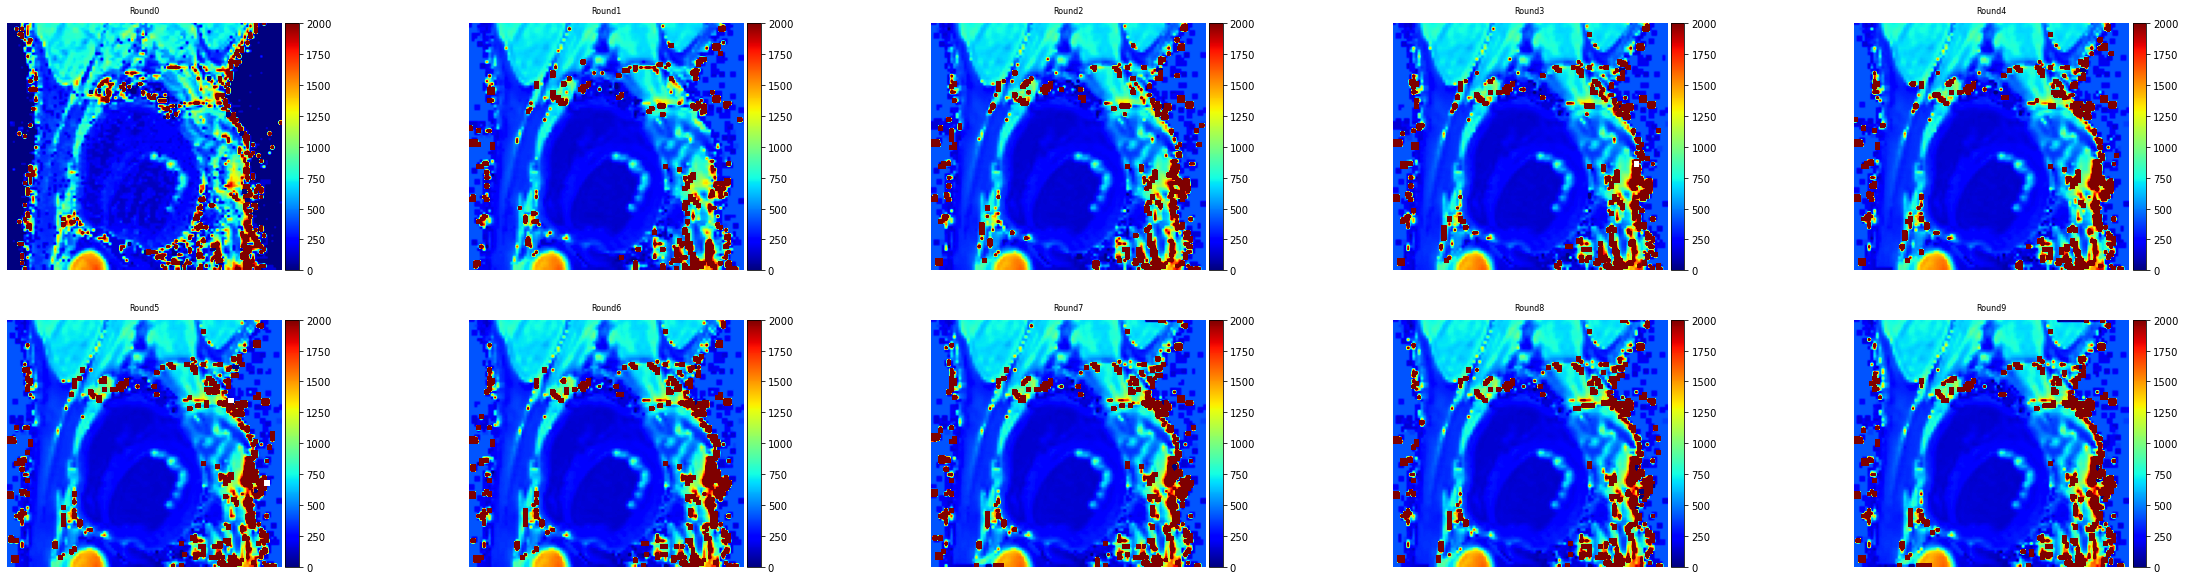

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(40, 10))
title_font_size=8
title_pad = 10
for i, item in enumerate(T1s):
    ax = fig.add_subplot(2, int(rounds/2), 1+i)
    im = ax.imshow(item, cmap='jet', vmin=0, vmax=2000)
    ax.axis('off')
    ax.set_title(f"Round{i}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


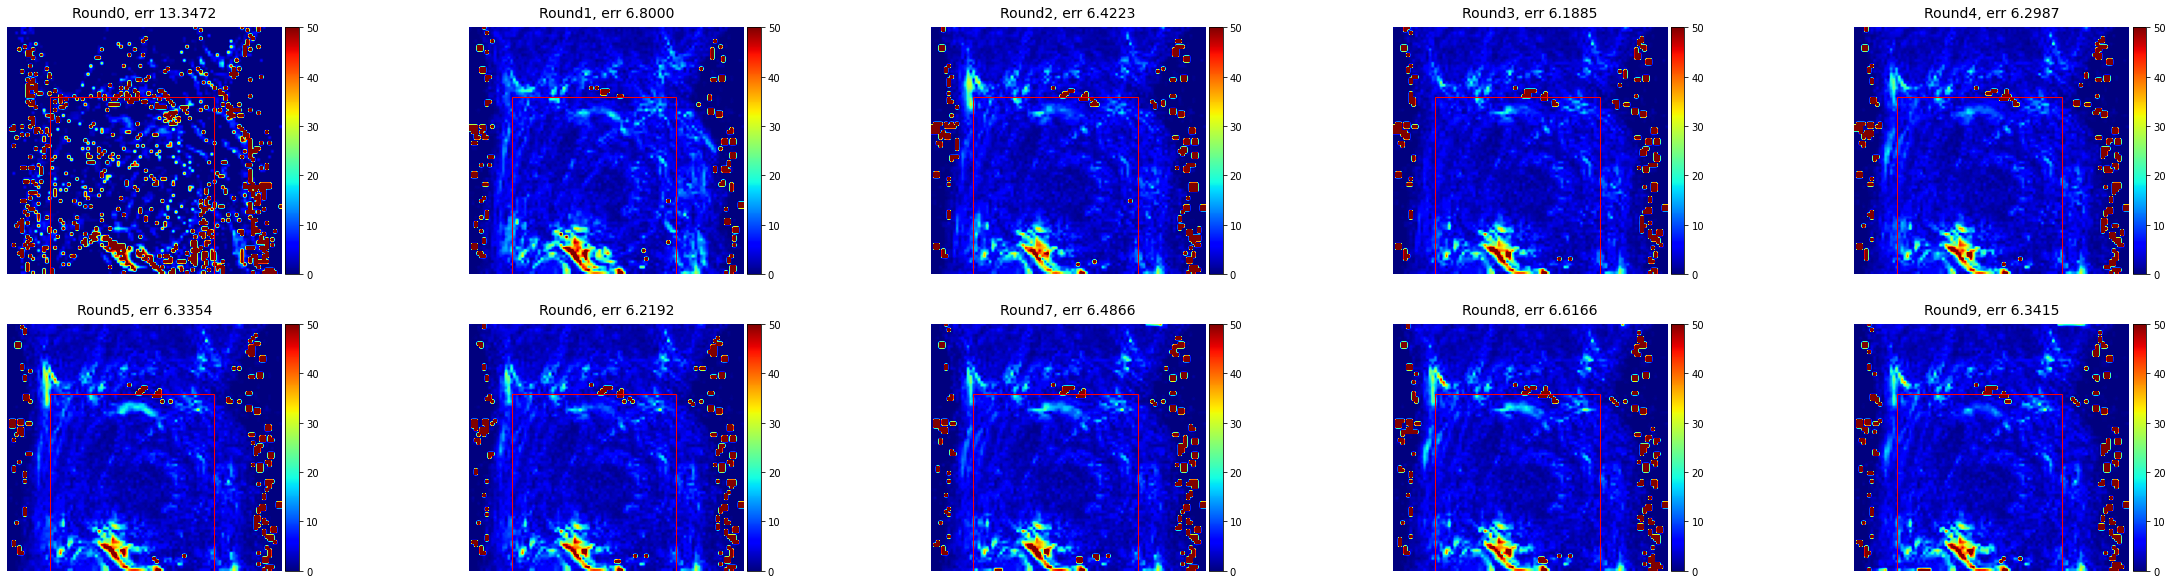

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
fig = plt.figure(figsize=(40, 10))
title_font_size=14
title_pad = 10
for i, item in enumerate(T1errs):
    ax = fig.add_subplot(2, int(rounds/2), 1+i)
    im = ax.imshow(item, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    err = np.mean(item[25:100, 15:75])
    ax.set_title(f"Round{i}, err {err:.4f}", fontsize=title_font_size, pad=title_pad)
    rect = patches.Rectangle((15, 25), 60, 70, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


In [28]:
sitk.Show(sitk.GetImageFromArray(registereds[2].transpose(2, 0, 1)))
sitk.Show(sitk.GetImageFromArray(frames.transpose(2, 0, 1)))

In [ ]:
# sitk.Show(sitk.GetImageFromArray(registereds[-1].transpose(2, 0, 1)))
sitk.Show(sitk.GetImageFromArray((registereds[-1] - frames).transpose(2, 0, 1)))